# phospho quickstart

In this quickstart, we will use the `lab` from the `phospho` package to figure out how many messages in a dataset are questions. 

1. First, we will detect events on a subset of the dataset using a pipeline powered by OpenAI GPT 3.5

2. Then, we will scale analytics with the `lab` optimizer. We will compare the event detection pipeline using MistralAI and a local Ollama model, and pick the best one in term of performance, speed and price.

3. Finally, we will use the `lab` to run the best model on the full dataset and visualize the results. 

This way, we will be able to run semantic analytics at scale on a dataset using LLMs. 

In [1]:
!pip install -q python-dotenv "phospho[lab]" 

In [1]:
# Load and check env variables
from dotenv import load_dotenv

load_dotenv()

from phospho import config

assert config.OPENAI_API_KEY is not None, "You need to set the OPENAI_API_KEY environment variable" 

## Setup the Event detection pipeline

In phospho, there are two important concepts:
- A workload, which is a set of jobs. Those jobs are run asynchronously and in parallel.
- A job, which is a python function that returns a JobResult. Jobs are parametrized with a JobConfig.

In this example, the Job is to detect an event ("Event Detection") using LLM self-reflection (we asked another LLM whether the event occured or not). We will try to detect the event: "The user asks a question to the assistant". 

In [5]:
from phospho import lab

# Create a workload in our lab
workload = lab.Workload()

# Add our job to the workload
workload.add_job(
    lab.Job(
        name="event_detection",
        id="question_answering",
        config=lab.EventConfig(
            event_name="Question Answering",
            event_description="User asks a question to the assistant",
            model="openai:gpt-3.5-turbo"
        )
    )
)

Now that everything is set up, we can run the pipeline on a Message. 

We want to detect whether the user asks a question. Sometimes, it's easy: there is a question mark. But sometimes, it's not: you understand that it is a question only through context and semantics. That's why you need an LLM.

In [6]:
await workload.async_run(
    messages=[
        # This message is a question, very simple to detect. 
        lab.Message(
            id="message_1",
            content="What is the capital of France?",
        ),
        # This message is not a question, so it should not be detected.
        lab.Message(
            id="message_2",
            content="I don't like croissants.",
        ),
        # This message is also a question, but it lacks a question mark. You need semantics to detect it.
        lab.Message(
            id="message_3",
            content="I wonder what's the capital of France...",
        )
    ]
)

for i in range(1, 4):
    print(f"In message {i}, the Event question answering was detected: {workload.results['message_'+str(i)]['question_answering'].value}")


In message 1, the Event question answering was detected: True
In message 2, the Event question answering was detected: False
In message 3, the Event question answering was detected: True


# Dataset analytics

Now, let's assume we want to find user questions in a large dataset. How would we do it?

Let's load a dataset of messages from huggingface.

In [7]:
!pip install -q datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index 0.9.6.post2 requires tiktoken>=0.3.3, which is not installed.
llama-index 0.9.6.post2 requires urllib3<2, but you have urllib3 2.2.1 which is incompatible.


In [8]:
from datasets import load_dataset

dataset = load_dataset("daily_dialog")

/Users/nicolasoulianov/anaconda3/envs/phospho-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This dataset has more than 10 000 samples. That's a lot and running analytics on it can quickly become pricy. So let's just select a subsample of it.

In [9]:
dataset["train"]

Dataset({
    features: ['dialog', 'act', 'emotion'],
    num_rows: 11118
})

In [10]:
# Generate a sub dataset with 30 messages
sub_dataset = dataset["train"].select(range(30))

# Let's print one of the messages
print(sub_dataset[0]["dialog"][0])

# Build the message list for our lab
messages = []
for row in sub_dataset:
    text = row["dialog"][0]
    messages.append(lab.Message(content=text))

Say , Jim , how about going for a few beers after dinner ? 


Now, let's run the analytics pipeline on the subset. 

The workload run is **asynchronous** and **parallelized**, which means this will go much faster than just writing a for loop.

In [11]:
# Run the lab on it
# The job will be run with the default model (openai:gpt-3.5-turbo)
workload_results = await workload.async_run(messages=messages)

In [12]:
# Print the results
for message_id, jobs in workload_results.items():
    print(f"Message {message_id} was a question: {jobs['question_answering'].value}")

Message 77dc8427821a4dada22beb6c9a3becda was a question: False
Message 105c1eb1d9f1424ea22ca85caaed8032 was a question: True
Message e3bd8de153da4de6b1bdce94375f914b was a question: True
Message c710e6f1ffcd44bc9de5d7436d08b4a7 was a question: False
Message 448d63564748440c986eb7e73e5f312e was a question: False
Message 95b8f62d82fb4a7d918e706bad488f04 was a question: True
Message d7d819fb98e647ae912d74c769659d61 was a question: False
Message f11e87af94c9456ea7bf6d8ae24e587a was a question: False
Message 1f4a7597561b4667b38002a53baefe2f was a question: True
Message ee7d0c911e44494da363ec1eb16f1e8b was a question: True
Message 084acb47636f45348f0ec7588c8cf16f was a question: True
Message 571902cf9ab84dcc8b609b02f2f092a0 was a question: False
Message 673762a4a2d94f94904588b826286754 was a question: False
Message 2bfcbc31b4ce459eb7014f4da63e0e38 was a question: True
Message 70cae17e2c62473485a214fcfba91274 was a question: False
Message 90757f1818bc45deb2a97aac263d6708 was a question: False

## Optimize the pipeline

Running semantic analytics with an LLM is great. But it's expensive and slow.

You likely want to try other model providers, such as Mistral, or even small local models. But how do they compare?

Let's run the pipeline on these models, and then figure out which one matches the reference, GPT-4. 

For the purpose of this demo, we consider a considertion good enough if it matches gpt-4 on at least 80% of the dataset. Good old Paretto.

### Installation and setup

You will need:
- a Mistral AI API key (find yours [here](https://console.mistral.ai/api-keys/))
- Ollama running on your local machine, with the Mistral 7B model installed. You can find the installation instructions for Ollama [here](https://ollama.com)

In [13]:
from phospho import config

# Check the environment variable
assert config.MISTRAL_API_KEY is not None, "You need to set the MISTRAL_API_KEY environment variable"

In [16]:
from phospho.lab.language_models import get_sync_client

# Create a client
ollama = get_sync_client("ollama")

try:
  # Let's check we can reach your local Ollama API
  response = ollama.chat.completions.create(model='mistral', messages=[
    {
      'role': 'user',
      'content': 'What is the best French cheese? Keep your answer short.',
    },
  ])
  print(response.choices[0].message.content)
except Exception as e:
  print(f"Error: {e}")
  print("You need to have a local Ollama server running to continue and the mistral model downloaded. \nRemove references to Ollama otherwise.")


The best French cheese varies by personal taste and region. But some renowned options include Roquefort, Brie, Comté, Camembert, and Reblochon.


### Compute the results with the alternative configurations

To run the jobs on multiple models at the same time, we will simply set up our job with a different configuration. 

In [30]:
from typing import Literal

workload = lab.Workload()

# Setup the configs for our job
class EventConfig(lab.JobConfig):
    event_name: str
    event_description: str
    # Model are ordered from the least desired to the most desired
    # The default model is set to be the "reference"
    model: Literal["openai:gpt-4", "mistral:mistral-large-latest", "mistral:mistral-small-latest", "ollama:mistral"] = "openai:gpt-4"

# Add our job to the workload
workload.add_job(
    lab.Job(
        name="event_detection",
        id="question_answering",
        config=EventConfig(
            event_name="Question Answering",
            event_description="User asks a question to the assistant",
            model="openai:gpt-4"
        )
    )
)

We run the workload in the same way. 

In [31]:
workload_results = await workload.async_run(messages=messages, executor_type="parallel")

In [32]:
# Note the default model is currently set to "openai:gpt-4"
workload.jobs[0].config.model

'openai:gpt-4'

Now, let's also run the pipeline on alternative models. 

In [33]:
# Compute alternative results with the Mistral API and Ollama
await workload.async_run_on_alternative_configurations(messages=messages, executor_type="parallel")

We ask the workload to figure out which model is better. 

Note that this can actually work with any set of parameters, not just models. It's a flexible way to perform a grid search. 

In [34]:
workload.optimize_jobs(accuracy_threshold=0.8)

accuracies: [0.8666666666666667, 0.7333333333333333, 0.6]


Let's check what model was picked. 

In [36]:
# let's check the new model_id (if it has changed)
workload.jobs[0].config.model

'mistral:mistral-large-latest'

Interesting! We can run our pipeline with roughly the same accuracy using a smaller model. That's a lot of time, compute and money saved.

## Run our workload on the full dataset, with optimized parameters

Now that we have benchmarked different models for our Event detection pipeline, let's run the optimal configuration on a larger chunk of the dataset. 

In [37]:
sub_dataset = dataset["train"].select(range(200)) # Here you can just leave it as dataset["train"] if you want to use the whole dataset

# Build the message list for our lab
messages = []
for row in sub_dataset:
    text = row["dialog"][0]
    messages.append(lab.Message(content=text))

In [38]:
# The job will be runned with the best model (mistral:mistral-small-latest in our case)
workload_results = await workload.async_run(messages=messages, executor_type="parallel")

event_detection call to OpenAI API failed : Error code: 429 - {'message': 'Requests rate limit exceeded'}
event_detection call to OpenAI API failed : Error code: 429 - {'message': 'Requests rate limit exceeded'}
event_detection call to OpenAI API failed : Error code: 429 - {'message': 'Requests rate limit exceeded'}
event_detection call to OpenAI API failed : Error code: 429 - {'message': 'Requests rate limit exceeded'}
event_detection call to OpenAI API failed : Error code: 429 - {'message': 'Requests rate limit exceeded'}
event_detection call to OpenAI API failed : Error code: 429 - {'message': 'Requests rate limit exceeded'}
event_detection call to OpenAI API failed : Error code: 429 - {'message': 'Requests rate limit exceeded'}
event_detection call to OpenAI API failed : Error code: 429 - {'message': 'Requests rate limit exceeded'}
event_detection call to OpenAI API failed : Error code: 429 - {'message': 'Requests rate limit exceeded'}
event_detection call to OpenAI API failed : Er

## Analyze the results

Now, we were trying to see which share of the dataset is actually a question. Let's get the results as a dataframe and visualize them.  

In [39]:
# Using .results_df() we can get a pandas dataframe with the results
workload.results_df()

,question_answering
ed8d794d627041398b2ffa6b2aa22c44,False
5d44f42a604c4c93b2b72c466ded9924,True
2afa8d650c5b427a8d655495da1da0f0,True
f91acb1c813a444b9fd91bc325e2b669,True
6ba70422146747b7b18c94d01f853dd3,True
...,...
da6c6502ee014934a78d64dac285bbfb,None
02575f7bc8ca4ffa8a1d36e6a7216e84,True
05c57c22b9604034a767d4225c6a2c98,True
813ae652695b4762aabc2583be210c22,True


We can see that there are many questions in this dataset...

In [40]:
workload.results_df().groupby("question_answering").size()

question_answering
False    88
True     75
dtype: int64

Let's make a nice plot.

In [41]:
!pip install -q matplotlib

<Axes: xlabel='question_answering'>

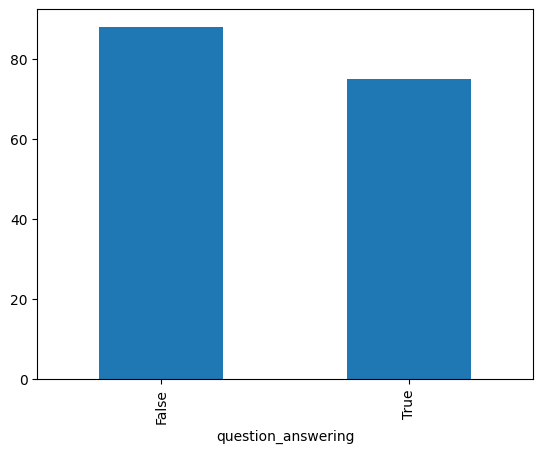

In [42]:
workload.results_df().groupby("question_answering").size().plot(kind="bar")

## Going further

You can use the `lab` to run other tasks, such as:
- Named Entity Recognition
- Sentiment Analysis
- Evaluations
- And more!

You can also play around with differnet models, different hyperparameters, and different datasets.

You want to have such analysis on your own LLM app, in real time? Check out the cloud hosted version of phospho, available on [phospho.ai](https://phospho.ai)